In [2]:
maxfit_l1_path = '../output/subtractive-ablation-mnist-models/relu-max_fit_l1.pkl'
all_modifications_path = '../output/ablation-mnist-models/relog-elliptical-maxout_4-mse-max_fit_l1-overlay.pkl'
minus_mse_path = '../output/ablation-mnist-models/relog-elliptical-maxout_4-max_fit_l1.pkl'
minus_l1_path = '../output/subtractive-ablation-mnist-models/relog-elliptical-maxout_4-mse-overlay.pkl'
minus_maxout_path = '../output/subtractive-ablation-mnist-models/relog-elliptical-mse-max_fit_l1-overlay.pkl'
minus_elliptical_path = '../output/subtractive-ablation-mnist-models/relog-maxout_4-mse-max_fit_l1-overlay.pkl'
minus_relog_path = '../output/subtractive-ablation-mnist-models/relu-elliptical-maxout_4-mse-max_fit_l1-overlay.pkl'

relu_path = '../output/ablation-mnist-models/relu.pkl'
relog_path = '../output/ablation-mnist-models/relog.pkl'
elliptical_path = '../output/subtractive-ablation-mnist-models/relu-elliptical.pkl'
elliptical_maxfit_path = '../output/subtractive-ablation-mnist-models/relu-elliptical-max_fit_l1.pkl'
relog_elliptical_maxfit_path = '../output/subtractive-ablation-mnist-models/relog-elliptical-max_fit_l1.pkl'
relu_elliptical_maxout_path = '../output/subtractive-ablation-mnist-models/relu-elliptical-max_fit-maxout.pkl'
relu_elliptical_maxfit_maxout_path = '../output/subtractive-ablation-mnist-models/relu-elliptical-maxout.pkl'
maxout_path = '../output/subtractive-ablation-mnist-models/relu-maxout.pkl'
minmaxout_path = '../output/subtractive-ablation-mnist-models/relu-minmaxout.pkl'
mse_path = '../output/subtractive-ablation-mnist-models/relu-mse.pkl'
overlay_path = '../output/subtractive-ablation-mnist-models/relu-mse-overlay.pkl'
maxfit_path = '../output/subtractive-ablation-mnist-models/relu-max_fit_l1.pkl'

In [3]:
import sys
sys.path.append('..')

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
import torch
import torchvision
import numpy as np
from torch.nn.functional import softmax
import os

In [5]:
def load_model(path):
    return torch.load(path, map_location=torch.device('cpu'))

In [7]:
model_a = load_model(relu_path)
model_b = load_model(all_modifications_path)

In [8]:
dataset = torchvision.datasets.MNIST(
            root='../mnist',
            train=True,
            transform=torchvision.transforms.ToTensor(), 
            download=False,
        )
loader = torch.utils.data.DataLoader(dataset, batch_size=10000, shuffle=False)

In [57]:
x, y = next(iter(loader))

In [78]:
from train import cifar_stats

# levels of noise
k = torch.linspace(0, 1, 101).reshape(-1, 1, 1, 1)

softmax_dim1 = lambda x: softmax(x, dim=1)

def denormalize_cifar_images(batch):
    means, stds = cifar_stats
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return batch * stds + means

class Plotter(object):

    def __init__(self, idx=None, is_cifar=False):
        self.is_cifar = is_cifar
        idx = idx or np.random.randint(x.shape[0])
        print("Plotting image at index %d" % idx)
        sample1 = x[[idx]]
        if is_cifar:
            sample2 = torch.randn(*sample1.shape)
            self.xs = sample1 * (1-k) + sample2 * k
        else:
            sample2 = torch.rand(*sample1.shape)
            self.xs = sample1 * (1-k) + sample2 * k

    def plot_transition(self):
        if self.xs.shape[1] == 1: # black-and-white
            xs_vals = self.xs[:,0,:,:].numpy()
        elif self.xs.shape[1] == 3: # R-G-B
            if self.is_cifar:
                images = denormalize_cifar_images(self.xs)
            else:
                images = self.xs
            xs_vals = images.permute(0,2,3,1).numpy()
        else:
            raise ValueError('Unsupported image format')
        fig, ax = plt.subplots(1, 5, figsize=(20, 4))
        ax[0].imshow(xs_vals[0])
        ax[0].set_title('Noise level: 0%')
        ax[1].imshow(xs_vals[25])
        ax[1].set_title('Noise level: 25%')
        ax[2].imshow(xs_vals[50])
        ax[2].set_title('Noise level: 50%')
        ax[3].imshow(xs_vals[70])
        ax[3].set_title('Noise level: 75%')
        ax[4].imshow(xs_vals[100])
        ax[4].set_title('Noise level: 100%')

    def plot_predictions(self, model, name, normalize_func=softmax_dim1):
        model.eval()
        preds, _ = model(self.xs)
        if normalize_func is not None:
            preds = normalize_func(preds)
        c0, c1 = preds[0].argsort(descending=True)[:2]
        pred_on_noise = preds[-1].clone()
        pred_on_noise[c0] = pred_on_noise[c1] = -np.inf # ignore the classes we have chosen already
        c2, c3 = pred_on_noise.argsort(descending=True)[:2]
        k_vals = k.flatten().numpy()
        for c in [c0, c1, c2, c3]:
            c = c.item()
            plt.plot(k_vals, preds[:,c].detach().numpy(), label='prediction: %d' %(c))
        plt.title('Model: ' + name)
        plt.legend()

In [62]:
p = Plotter(84)

Plotting image at index 84


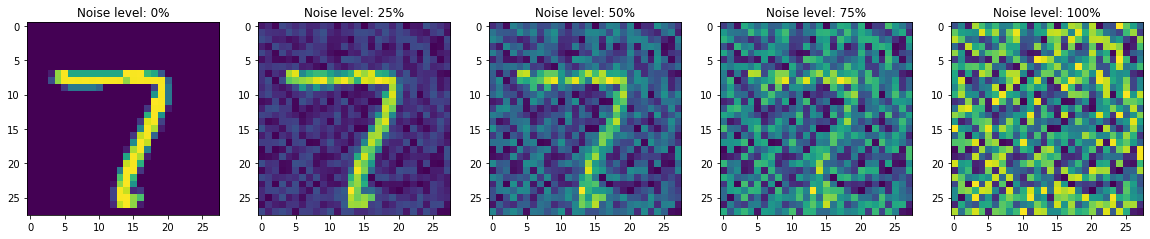

In [63]:
p.plot_transition()

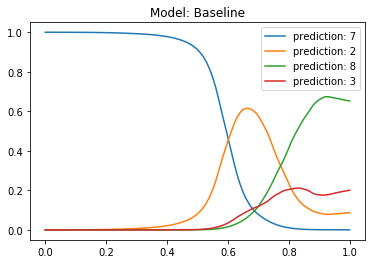

In [13]:
p.plot_predictions(model_a, 'Baseline')

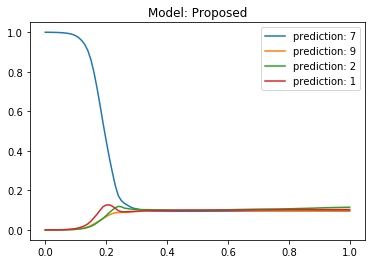

In [14]:
p.plot_predictions(model_b, 'Proposed')

In [15]:
p = Plotter(41)

Plotting image at index 41


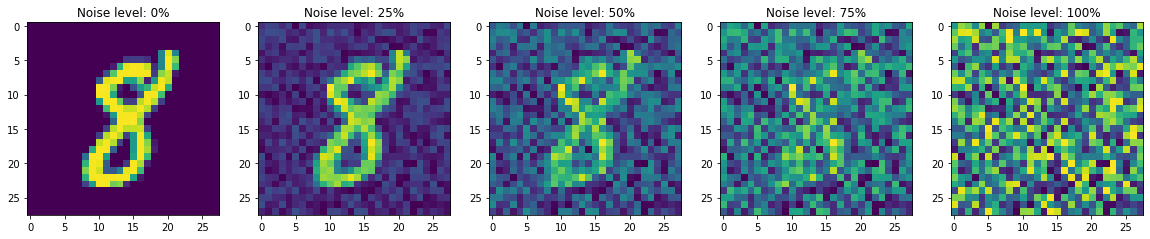

In [16]:
p.plot_transition()

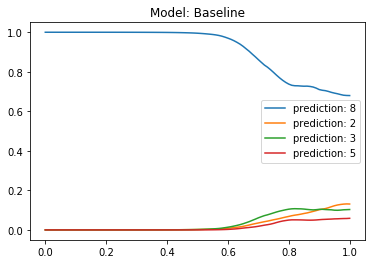

In [17]:
p.plot_predictions(model_a, 'Baseline')

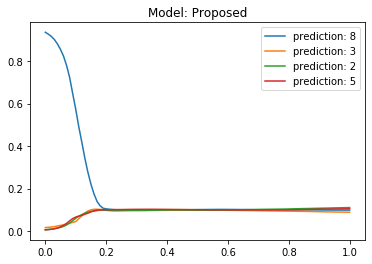

In [18]:
p.plot_predictions(model_b, 'Proposed')

In [19]:
p = Plotter(8)

Plotting image at index 8


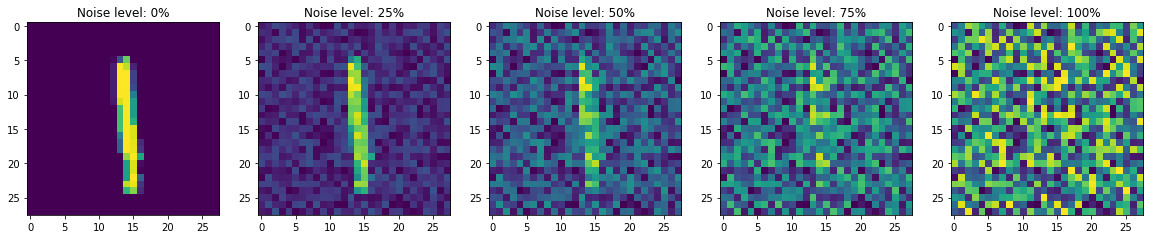

In [20]:
p.plot_transition()

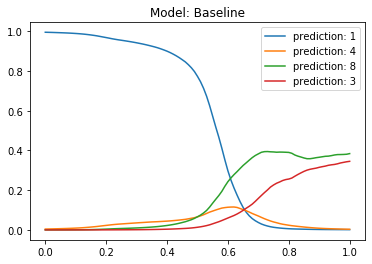

In [21]:
p.plot_predictions(model_a, 'Baseline')

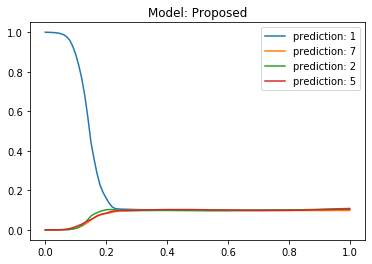

In [22]:
p.plot_predictions(model_b, 'Proposed')

Plotting image at index 2978


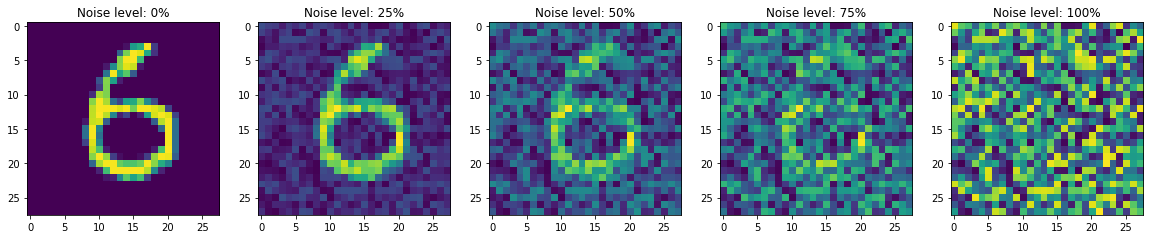

In [23]:
p = Plotter(2978)
p.plot_transition()

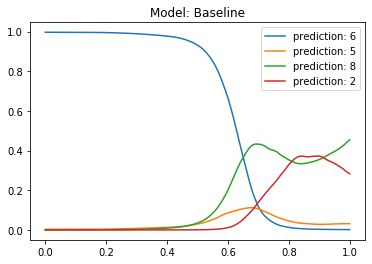

In [24]:
p.plot_predictions(model_a, 'Baseline')

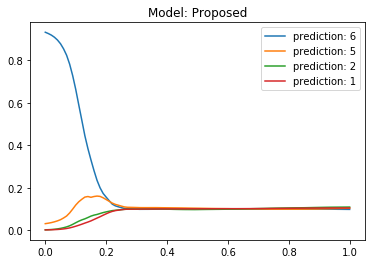

In [25]:
p.plot_predictions(model_b, 'Proposed')

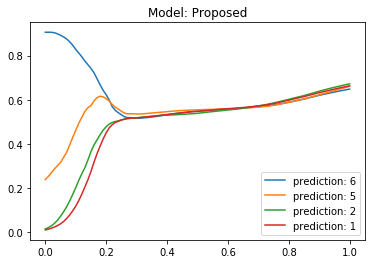

In [26]:
p.plot_predictions(model_b, 'Proposed', normalize_func=torch.sigmoid)

# Classifying rubbish class examples

In [36]:
noise_images = torch.rand(*x.shape)
# noise_images = torch.randn(*x.shape)

def measure_accuracy_on_noise(model):
    preds, _ = model(noise_images)
    max_probs, _ = softmax(preds, dim=1).max(dim=1)
    accuracies = (max_probs < 0.5).float().reshape(-1, 100).mean(dim=1)
    return accuracies.mean(), accuracies.std()

In [28]:
paths = [relu_path, relog_path, maxout_path,
         minmaxout_path, elliptical_path, maxfit_path, 
         mse_path, overlay_path, elliptical_maxfit_path, 
         relog_elliptical_maxfit_path, minus_mse_path,
         relu_elliptical_maxout_path, relu_elliptical_maxfit_maxout_path]

In [90]:
for path in paths:
    print('%s: %.2f (std=%.2f)' %(os.path.basename(path), *measure_accuracy_on_noise(load_model(path))))

relu.pkl: 0.28 (std=0.05)
relog.pkl: 0.06 (std=0.03)
relu-maxout.pkl: 0.05 (std=0.02)
relu-minmaxout.pkl: 0.02 (std=0.01)
relu-elliptical.pkl: 0.01 (std=0.01)
relu-max_fit_l1.pkl: 0.48 (std=0.05)
relu-mse.pkl: 0.08 (std=0.03)
relu-mse-overlay.pkl: 1.00 (std=0.00)
relu-elliptical-max_fit_l1.pkl: 0.00 (std=0.00)
relog-elliptical-max_fit_l1.pkl: 0.00 (std=0.00)
relog-elliptical-maxout_4-max_fit_l1.pkl: 1.00 (std=0.00)
relu-elliptical-max_fit-maxout.pkl: 0.79 (std=0.04)
relu-elliptical-maxout.pkl: 0.03 (std=0.02)


In [89]:
# check if the architecture is correct
load_model(relu_elliptical_maxout_path)

CNN(
  (features): Sequential(
    (0): EllipticalCNN(
      1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)
      (_quadratic): AbsConv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    )
    (1): FoldingMaxout(use_min=False, k=4)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): EllipticalCNN(
      16, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)
      (_quadratic): AbsConv2d(16, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    )
    (5): FoldingMaxout(use_min=False, k=4)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Elliptical(
      in_features=1568, out_features=40, bias=True
      (_quadratic): AbsLinear(in_features=1568, out_features=40, bias=False)
    )
    (1): FoldingMaxout(use_min=False, k=4)
  )
)

In [29]:
measure_accuracy_on_noise(model_a)

tensor(0.2786)

In [30]:
measure_accuracy_on_noise(model_b)

tensor(1.)

## Subtractive ablation

In [31]:
minus_l1 = load_model(minus_l1_path)
minus_maxout = load_model(minus_maxout_path)
minus_elliptical = load_model(minus_elliptical_path)
minus_relog = load_model(minus_relog_path)

In [32]:
measure_accuracy_on_noise(minus_l1)

tensor(1.)

In [33]:
measure_accuracy_on_noise(minus_maxout)

tensor(1.)

In [34]:
measure_accuracy_on_noise(minus_elliptical)

tensor(1.)

In [35]:
measure_accuracy_on_noise(minus_relog)

tensor(1.)

Plotting image at index 223


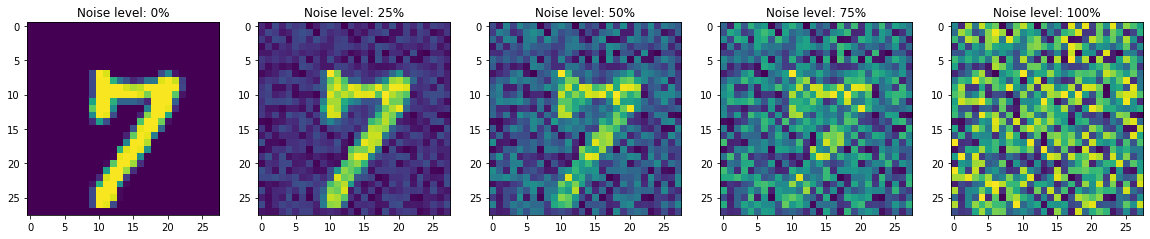

In [36]:
p = Plotter(223)
p.plot_transition()

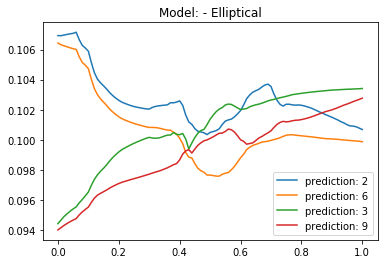

In [37]:
p.plot_predictions(minus_elliptical, '- Elliptical')

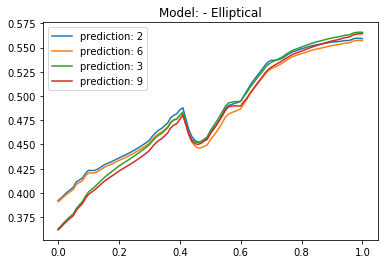

In [38]:
p.plot_predictions(minus_elliptical, '- Elliptical', normalize_func=torch.sigmoid)

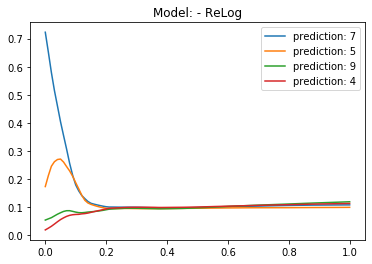

In [39]:
p.plot_predictions(minus_relog, '- ReLog')

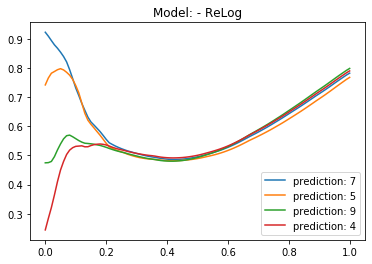

In [40]:
p.plot_predictions(minus_relog, '- ReLog', normalize_func=torch.sigmoid)

In [41]:
minus_relog_elliptical = load_model('../output/subtractive-ablation-mnist-models/relu-maxout_4-mse-max_fit_l1-overlay.pkl')
minus_relog_maxout = load_model('../output/subtractive-ablation-mnist-models/relu-elliptical-mse-max_fit_l1-overlay.pkl')

In [42]:
measure_accuracy_on_noise(minus_relog_elliptical)

tensor(1.)

In [43]:
measure_accuracy_on_noise(minus_relog_maxout)

tensor(1.)

In [44]:
just_mse = load_model(mse_path)
just_mse_overlay = load_model(overlay_path)

In [45]:
measure_accuracy_on_noise(just_mse_overlay)

tensor(1.)

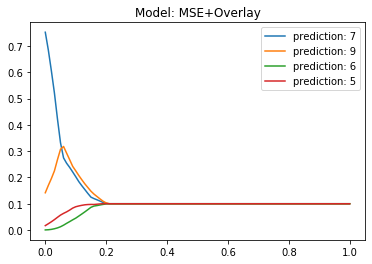

In [46]:
p.plot_predictions(just_mse_overlay, 'MSE+Overlay')

In [47]:
measure_accuracy_on_noise(just_mse)

tensor(0.0794)

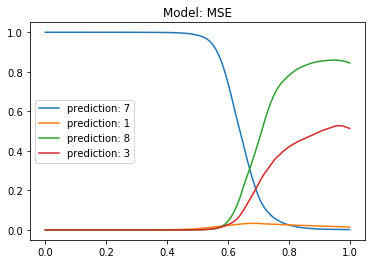

In [48]:
p.plot_predictions(just_mse, 'MSE', normalize_func=torch.sigmoid)

Notice that you can't train on negative examples (overlay) without enabling MSE training.

# All modifications except MSE training

In [81]:
minus_mse = torch.load(minus_mse_path, map_location=torch.device('cpu'))

In [82]:
measure_accuracy_on_noise(minus_mse)

(tensor(0.9986), tensor(0.0035))

In [52]:
p = Plotter(6)

Plotting image at index 6


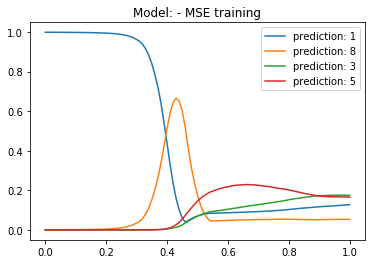

In [53]:
p.plot_predictions(minus_mse, '- MSE training')

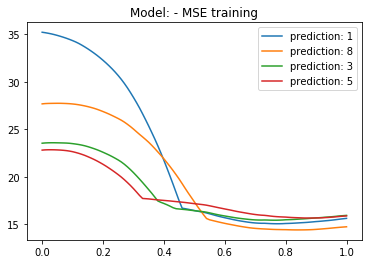

In [54]:
p.plot_predictions(minus_mse, '- MSE training', normalize_func=None)

Plotting image at index 29


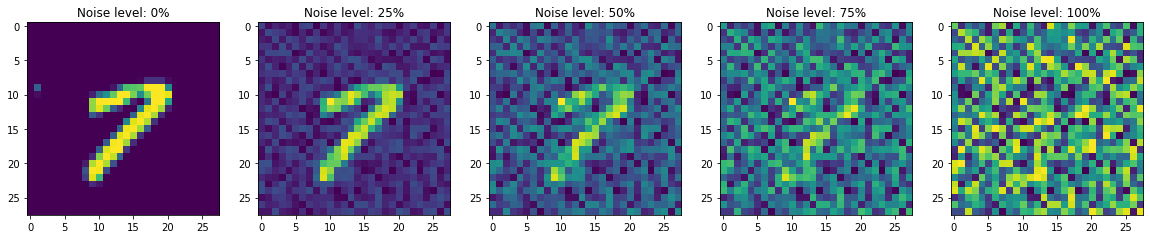

In [55]:
p = Plotter(29)
p.plot_transition()

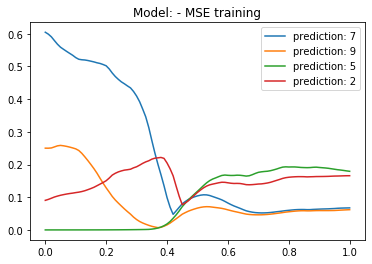

In [56]:
p.plot_predictions(minus_mse, '- MSE training')

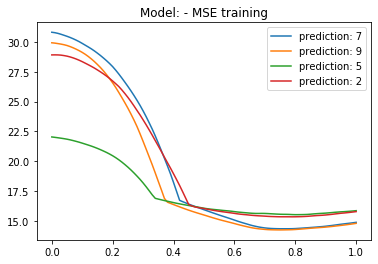

In [57]:
p.plot_predictions(minus_mse, '- MSE training', normalize_func=None)

Plotting image at index 21


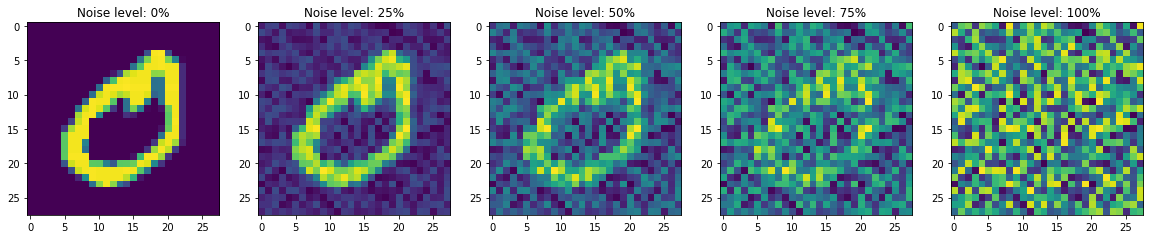

In [58]:
p = Plotter(21)
p.plot_transition()

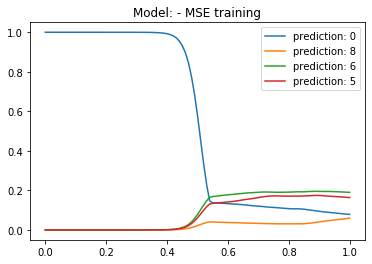

In [59]:
p.plot_predictions(minus_mse, '- MSE training')

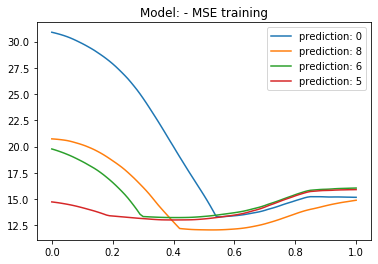

In [60]:
p.plot_predictions(minus_mse, '- MSE training', normalize_func=None)

# Check another model: ReLog (no MSE training)

In [65]:
relog = torch.load(relog_path, map_location=torch.device('cpu'))

Plotting image at index 4141


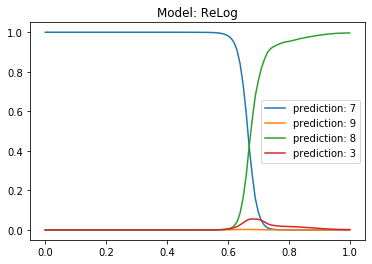

In [66]:
Plotter(4141).plot_predictions(relog, 'ReLog')

Plotting image at index 4176


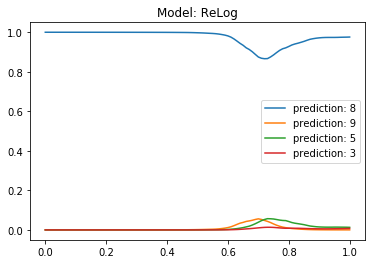

In [63]:
Plotter(4176).plot_predictions(relog, 'ReLog')

Plotting image at index 8020


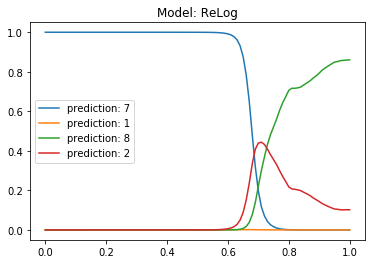

In [64]:
Plotter(8020).plot_predictions(relog, 'ReLog')

In [67]:
measure_accuracy_on_noise(relog)

tensor(0.0614)

# CIFAR-10 models

In [49]:
cifar10_baseline_path = '../output/ablation-cifar10-models/relu.pkl'
cifar10_modified_path = '../output/ablation-cifar10-models2/relog-elliptical-maxout-maxfit_l1.pkl'

In [51]:
cifar10_model_a = load_model(cifar10_baseline_path)
cifar10_model_b = load_model(cifar10_modified_path)

In [64]:
transform_test = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(*cifar_stats)
])
cifar10_testset = torchvision.datasets.CIFAR10(root='../cifar10', train=False, download=False, transform=transform_test)
cifar10_testloader = torch.utils.data.DataLoader(cifar10_testset, batch_size=256, shuffle=False, num_workers=2)

In [75]:
x, y = next(iter(cifar10_testloader))

In [79]:
p = Plotter(3, is_cifar=True)

Plotting image at index 3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


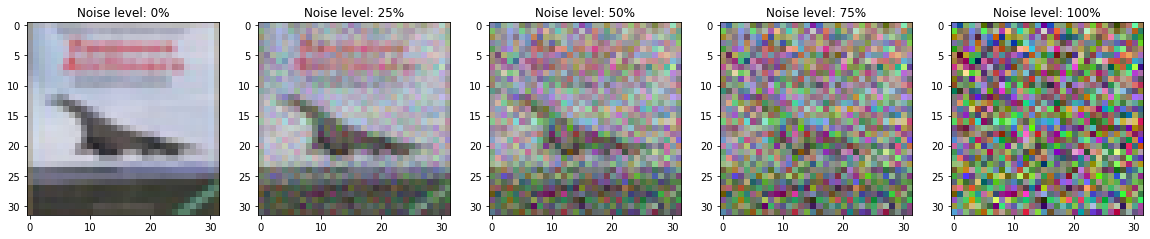

In [80]:
p.plot_transition()

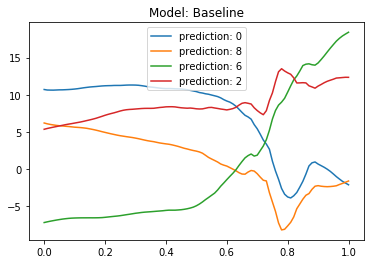

In [81]:
p.plot_predictions(cifar10_model_a, 'Baseline', normalize_func=None)

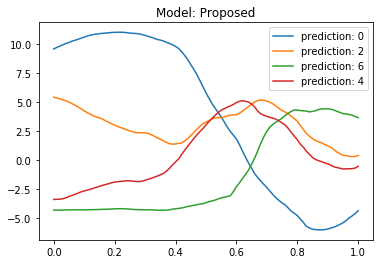

In [82]:
p.plot_predictions(cifar10_model_b, 'Proposed', normalize_func=None)

In [113]:
p = Plotter(138, is_cifar=True)

Plotting image at index 138


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


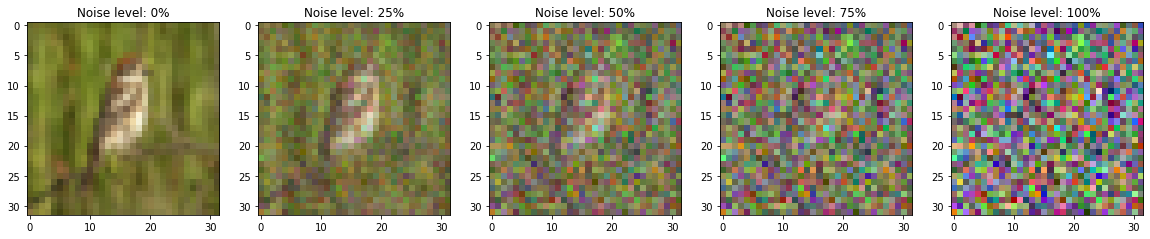

In [114]:
p.plot_transition()

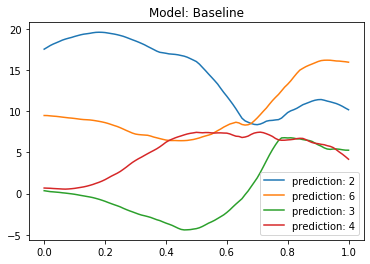

In [115]:
p.plot_predictions(cifar10_model_a, 'Baseline', normalize_func=None)

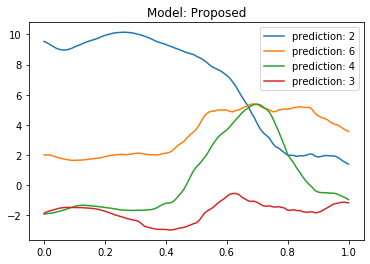

In [116]:
p.plot_predictions(cifar10_model_b, 'Proposed', normalize_func=None)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


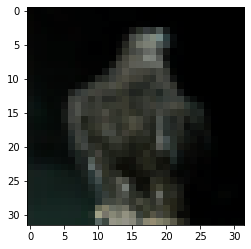

In [109]:
plt.imshow(x2[118].permute(1, 2, 0))

In [117]:
p = Plotter(118, is_cifar=True)

Plotting image at index 118


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


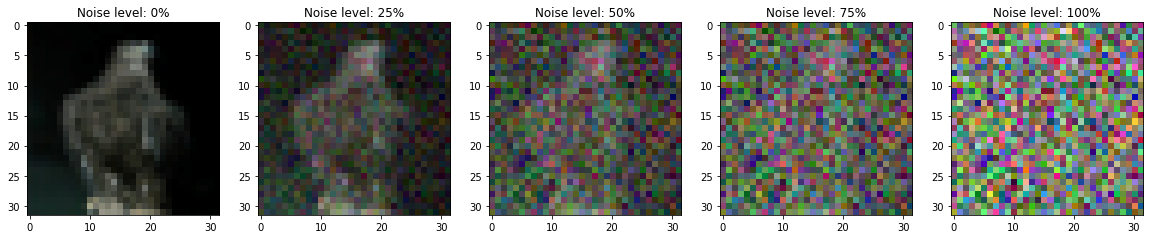

In [118]:
p.plot_transition()

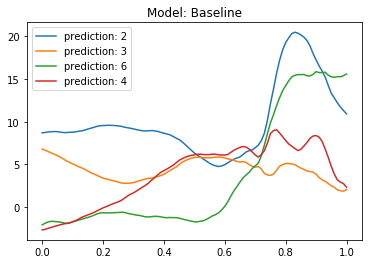

In [119]:
p.plot_predictions(cifar10_model_a, 'Baseline', normalize_func=None)

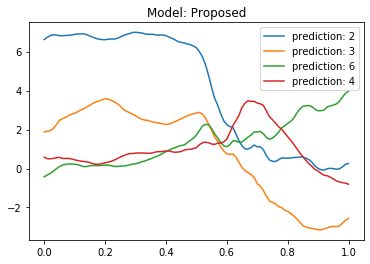

In [120]:
p.plot_predictions(cifar10_model_b, 'Proposed', normalize_func=None)

In [121]:
p = Plotter(197, is_cifar=True)

Plotting image at index 197


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


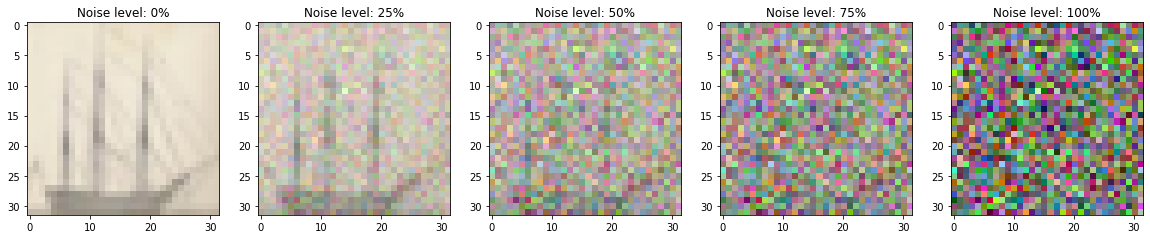

In [122]:
p.plot_transition()

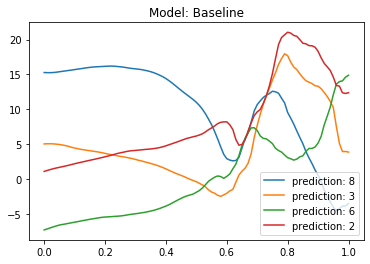

In [123]:
p.plot_predictions(cifar10_model_a, 'Baseline', normalize_func=None)

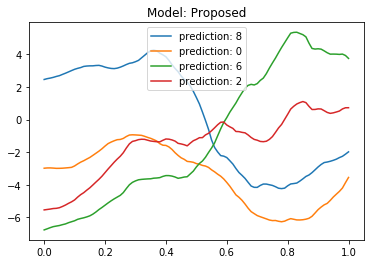

In [124]:
p.plot_predictions(cifar10_model_b, 'Proposed', normalize_func=None)

## Measure on noise

In [156]:
noise_images = torch.randn(1000, 3, 32, 32) # used in measure_accuracy_on_noise()

In [157]:
measure_accuracy_on_noise(cifar10_model_a)

(tensor(0.), tensor(0.))

In [158]:
measure_accuracy_on_noise(cifar10_model_b)

(tensor(0.0210), tensor(0.0145))

In [159]:
from scipy import stats

def compare_max_probs_on_noise(model1, model2):
    preds1, _ = model1(noise_images)
    max_probs1, _ = softmax(preds1, dim=1).max(dim=1)
    print('Model1: mean=%f, std=%f' %(max_probs1.mean().item(), max_probs1.std().item()))
    
    preds2, _ = model2(noise_images)
    max_probs2, _ = softmax(preds2, dim=1).max(dim=1)
    print('Model2: mean=%f, std=%f' %(max_probs2.mean().item(), max_probs2.std().item()))
    
    _, p_value = stats.ttest_ind(max_probs1.detach().numpy(), max_probs2.detach().numpy())
    print('p-value:', p_value)
    return max_probs1.mean(), max_probs2.mean()

In [160]:
compare_max_probs_on_noise(cifar10_model_a, cifar10_model_b)

Model1: mean=0.939280, std=0.105078
Model1: mean=0.869276, std=0.123949
1.762729664871786e-40


(tensor(0.9393, grad_fn=<MeanBackward0>),
 tensor(0.8693, grad_fn=<MeanBackward0>))